## Countrywide Regression Analysis with Commercial data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost.sklearn import XGBRegressor
import xgboost as xgb

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

In [2]:
# Read input
data = pd.read_csv('Regression_new.csv')
corr = data.corr()

In [3]:
data

,Year,Month,AK,AL,AR,AZ,CA,CO,CT,DE,...,area,population,solar-generation,Spring,Summer,Fall,Winter,Residential_Usage,Industrial_Usage,Commercial_Usage
0,2014,1,1,0,0,0,0,0,0,0,...,664988,736283,0,0,0,0,1,230.0,122,250
1,2014,1,0,1,0,0,0,0,0,0,...,52420,4841799,0,0,0,0,1,3786.0,2778,1999
2,2014,1,0,0,1,0,0,0,0,0,...,53178,2967392,0,0,0,0,1,2002.0,1303,950
3,2014,1,0,0,0,1,0,0,0,0,...,113990,6730413,34,0,0,0,1,2300.0,1149,2101
4,2014,1,0,0,0,0,1,0,0,0,...,163694,38596972,75,0,0,0,1,7773.0,3764,9426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,2019,12,0,0,0,0,0,0,0,0,...,9616,623651,3,0,0,0,1,203.0,120,162
3596,2019,12,0,0,0,0,0,0,0,0,...,71298,7698332,1,0,0,0,1,3871.0,1979,2611
3597,2019,12,0,0,0,0,0,0,0,0,...,65496,5836210,2,0,0,0,1,2029.0,1859,1954
3598,2019,12,0,0,0,0,0,0,0,0,...,24230,1781015,0,0,0,0,1,1174.0,1176,596


In [4]:
numeric_features=['Commercial_Retail Price','CLDD','TAVG','AWND','HTDD','area','population', 'solar-generation']

In [5]:
def cal_vif(df, feature_name):
    features= df[feature_name]
    X = add_constant(features)
    vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    
    return vif

In [6]:
cal_vif(data, numeric_features)

const                      6235.708533
Commercial_Retail Price       1.227648
CLDD                         30.904525
TAVG                        471.720786
AWND                          1.112152
HTDD                        318.152483
area                          1.073584
population                    1.768300
solar-generation              1.893651
dtype: float64

From the VIFs, we find out that `TAVG`, `HTDD`, and `CLDD` might exist collinearity, thus we decide to exclude `TAVG` this column when we do analysis.

In [7]:
numeric_features_adj=['Commercial_Retail Price','CLDD', 'AWND','HTDD','area','population', 'solar-generation']

In [8]:
cal_vif(data, numeric_features_adj)

const                      24.820905
Commercial_Retail Price     1.227648
CLDD                        1.776971
AWND                        1.111356
HTDD                        1.829683
area                        1.073583
population                  1.768189
solar-generation            1.893565
dtype: float64

The VIFs look fine now.

In [9]:
#deal with Multicollinearity, baseline issue
#drop year, month
data= data.drop(['Year', 'Month','PA','Spring','TAVG'],axis = 1)

## Train Test Split and Data Scaling

In [10]:
#Train-Test Split
train, test = train_test_split(data, test_size=0.2)

#splitX,y
def x_y_split(data):
    X = data.drop(['Industrial_Retail Price', 'Residential_Retail Price','Residential_Usage', 'Industrial_Usage', 'Commercial_Usage'],axis = 1)
    y = data['Commercial_Usage']
    return X,y

X_train,y_train = x_y_split(train)
X_test,y_test = x_y_split(test)

In [11]:
#categorize X features
categorical_feature_name = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL',
       'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA',
       'VT', 'WA', 'WI', 'WV', 'WY', 'Summer', 'Fall', 'Winter']

In [12]:
#Scale the data through Robust Scaler

def minmax_scaler(X_train, X_test):
    minMax_Scaler = MinMaxScaler()
    # fit and tranform the training data
    X_train[numeric_features_adj] = minMax_Scaler.fit_transform(X_train[numeric_features_adj]) 
    # tranform test data
    X_test[numeric_features_adj] = minMax_Scaler.transform(X_test[numeric_features_adj]) 
    return (X_train,X_test)

X_train, X_test = minmax_scaler(X_train, X_test)

## Linear Regression

In [13]:
def sm_regression(X_train,y_train,X_test,y_test):
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train)
    results = model.fit()
    results.params
    print(results.summary())
    predictions = results.predict(X_test)
    df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': predictions})
    
    return df_pred

In [14]:
df_pred=sm_regression(X_train, y_train, X_test, y_test)

                            OLS Regression Results                            
Dep. Variable:       Commercial_Usage   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     4692.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):               0.00
Time:                        09:08:44   Log-Likelihood:                -19911.
No. Observations:                2880   AIC:                         3.994e+04
Df Residuals:                    2821   BIC:                         4.029e+04
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2

In [15]:
df_pred

,Actual,Predicted
3060,203,1.335044
1433,5767,6211.417829
2849,307,284.000523
109,3542,3550.331896
952,1254,1474.726454
...,...,...
2199,323,274.565774
150,223,133.080167
3141,2725,2727.389581
437,3666,3555.891871


In [16]:
#Evaluate Performance: MAE, MSE, RMSE
def evaluate_performances(y_test, y_pred):
    print('Performance Evaluation')
    print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, y_pred)))

In [17]:
# Evaluate Performance
evaluate_performances(df_pred['Actual'], df_pred['Predicted'])


Performance Evaluation
Mean Absolute Error: 139.59305809080473
Mean Squared Error: 60937.57972502659
Root Mean Squared Error: 246.85538220793686


## Feature Importance

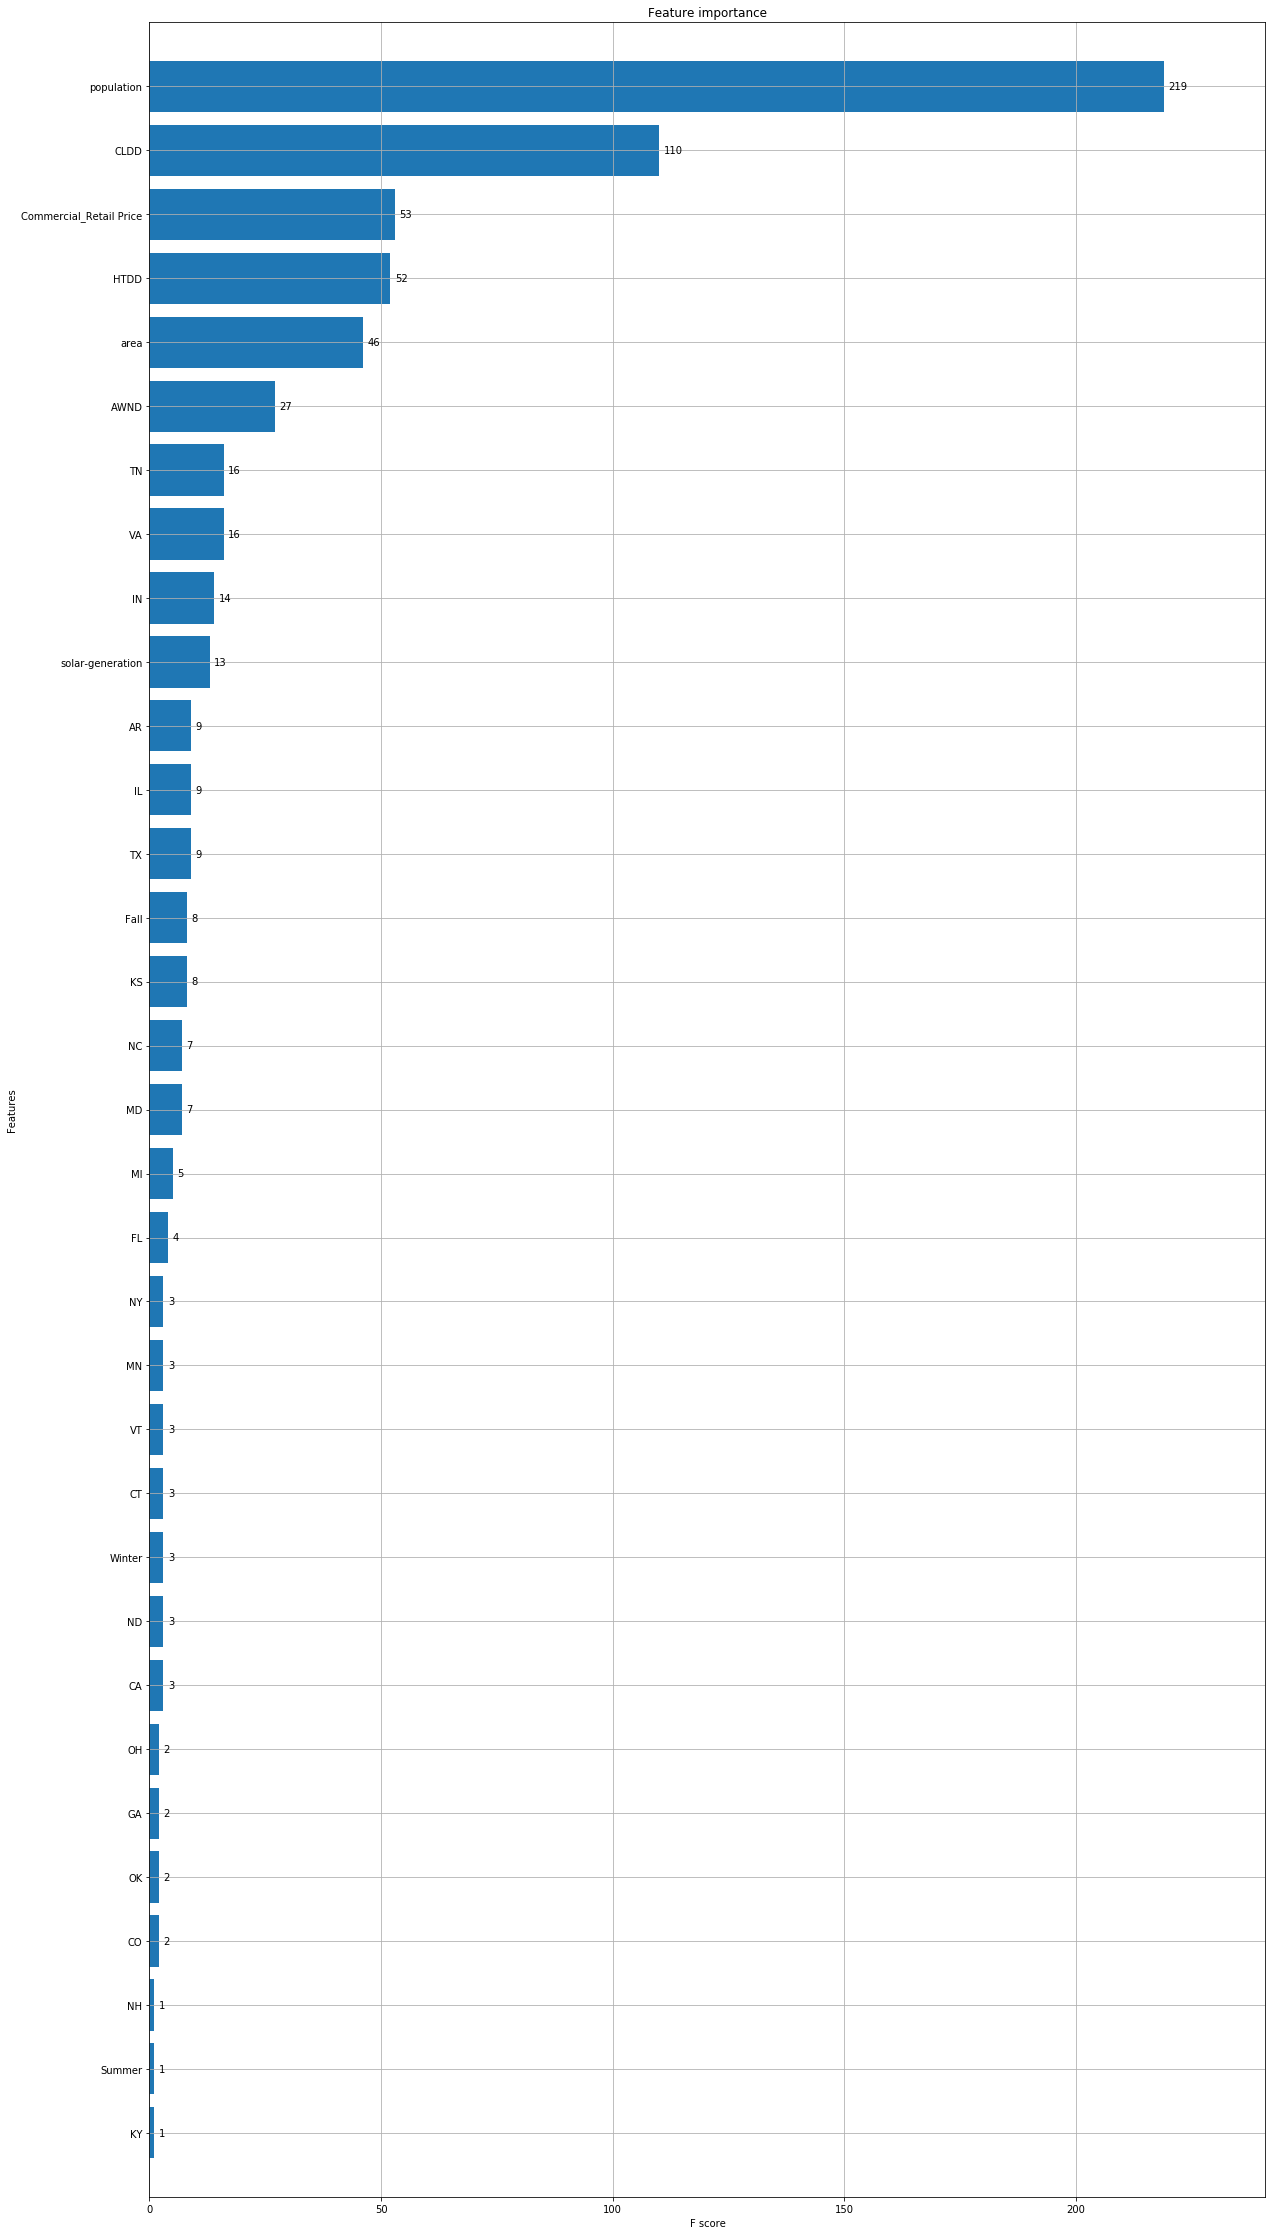

In [18]:
xgbRegressor = XGBRegressor(objective ='reg:squarederror')
xgbRegressor.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(20,40))
xgb.plot_importance(xgbRegressor, height=0.8, ax=ax)

## Visualization

In [19]:
# Correlation Analysis between Y and X's
def correlation_analysis(data, x_vars_list, y_vars_list):
    sns.pairplot(data, x_vars = x_vars_list, y_vars = y_vars_list, size=7, aspect=0.8,kind = 'reg')
#     plt.savefig("pairplot.jpg")
    plt.show()

In [20]:
#Visualize the output
def visualize_graph(df_pred):
    fig, axes = plt.subplots(3,1, figsize=(7,15))
    #Plot the result in line plot
    df_pred.plot.scatter(title="Actual vs. Predict result scatter plot",x='Actual', y='Predicted',ax=axes[0])
    #Plot the result in box plot
    df_pred.plot(title="Actual vs. Predict result box plot",kind='box',ax=axes[1])
    #Plot the result in terms of kernel density estimation
    df_pred.plot(title="Actual vs. Predict result kernel density estimation", kind='density',ax=axes[2]) 

In [21]:
# Visualization
def visualization(y_test, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30,20))
    fig.suptitle('Predicted and Actual plot')
    ax1.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax1.legend(loc="upper right")
    ax2.plot(range(len(y_test)),y_test,'r',label="actual")
    ax2.legend(loc="upper right")
    ax3.plot(range(len(y_pred)),y_pred,'b',label="predict")
    ax3.plot(range(len(y_test)),y_test,'r',label="test")
    ax3.legend(loc="upper right")
    plt.show()

C:\Users\Maggie\Anaconda3\envs\tensorflow_env\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


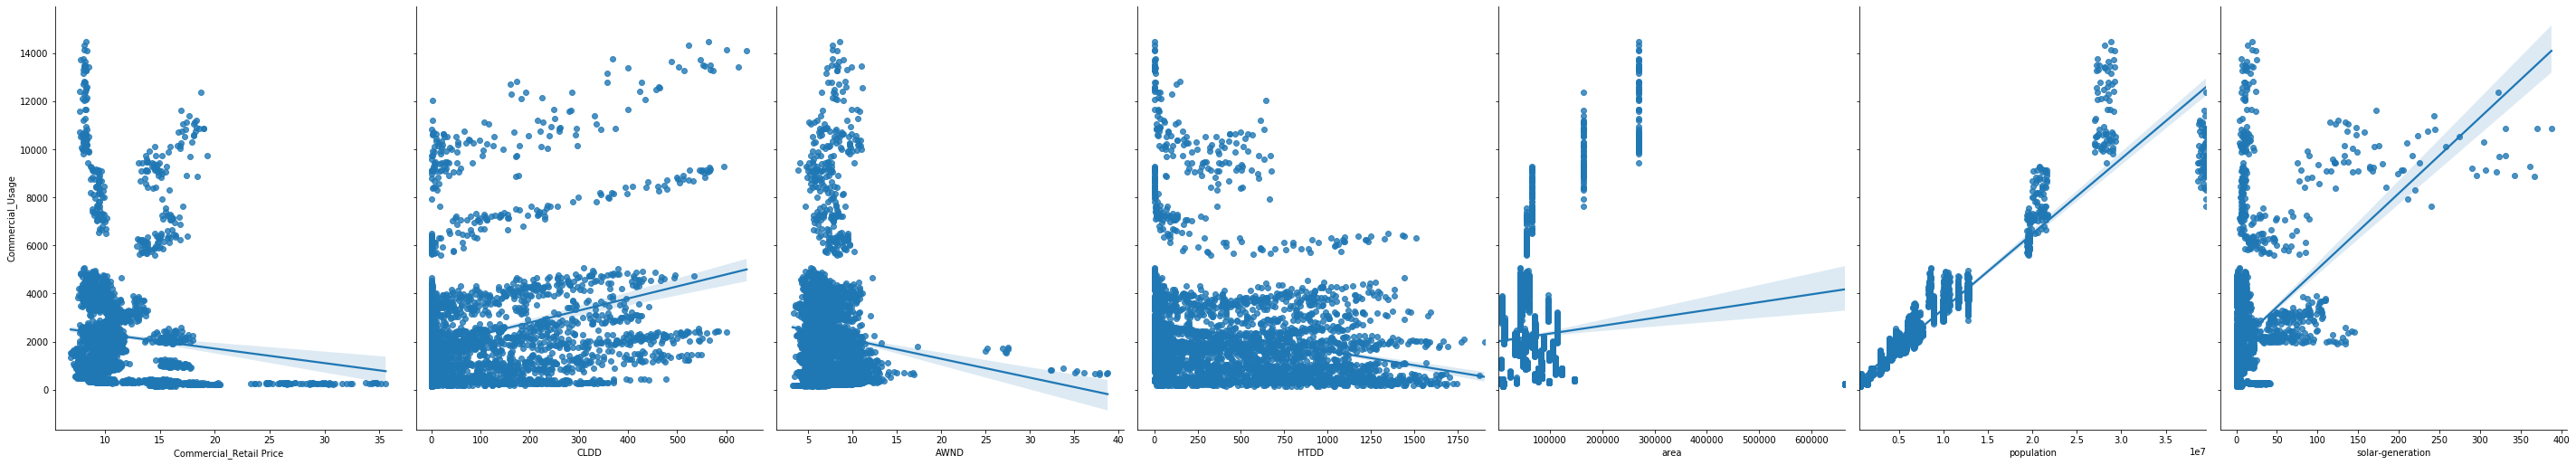

In [22]:
# Correlation Analysis
correlation_analysis(data, numeric_features_adj, ['Commercial_Usage'])

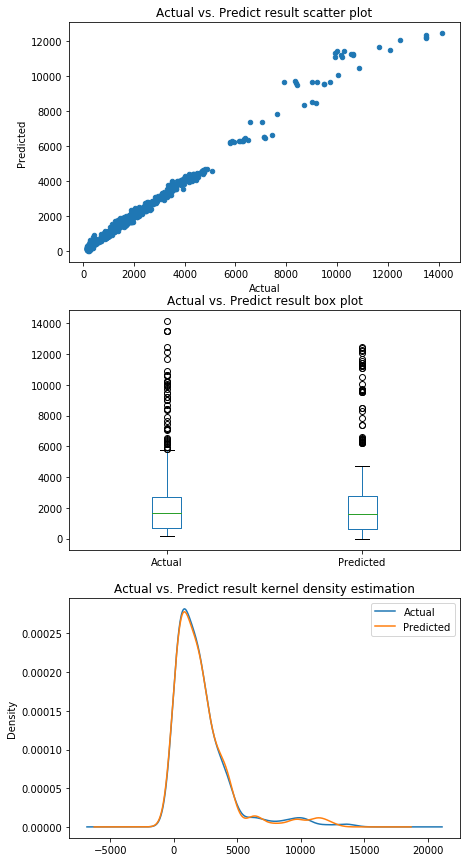

In [23]:
# Visualize Output
visualize_graph(df_pred)

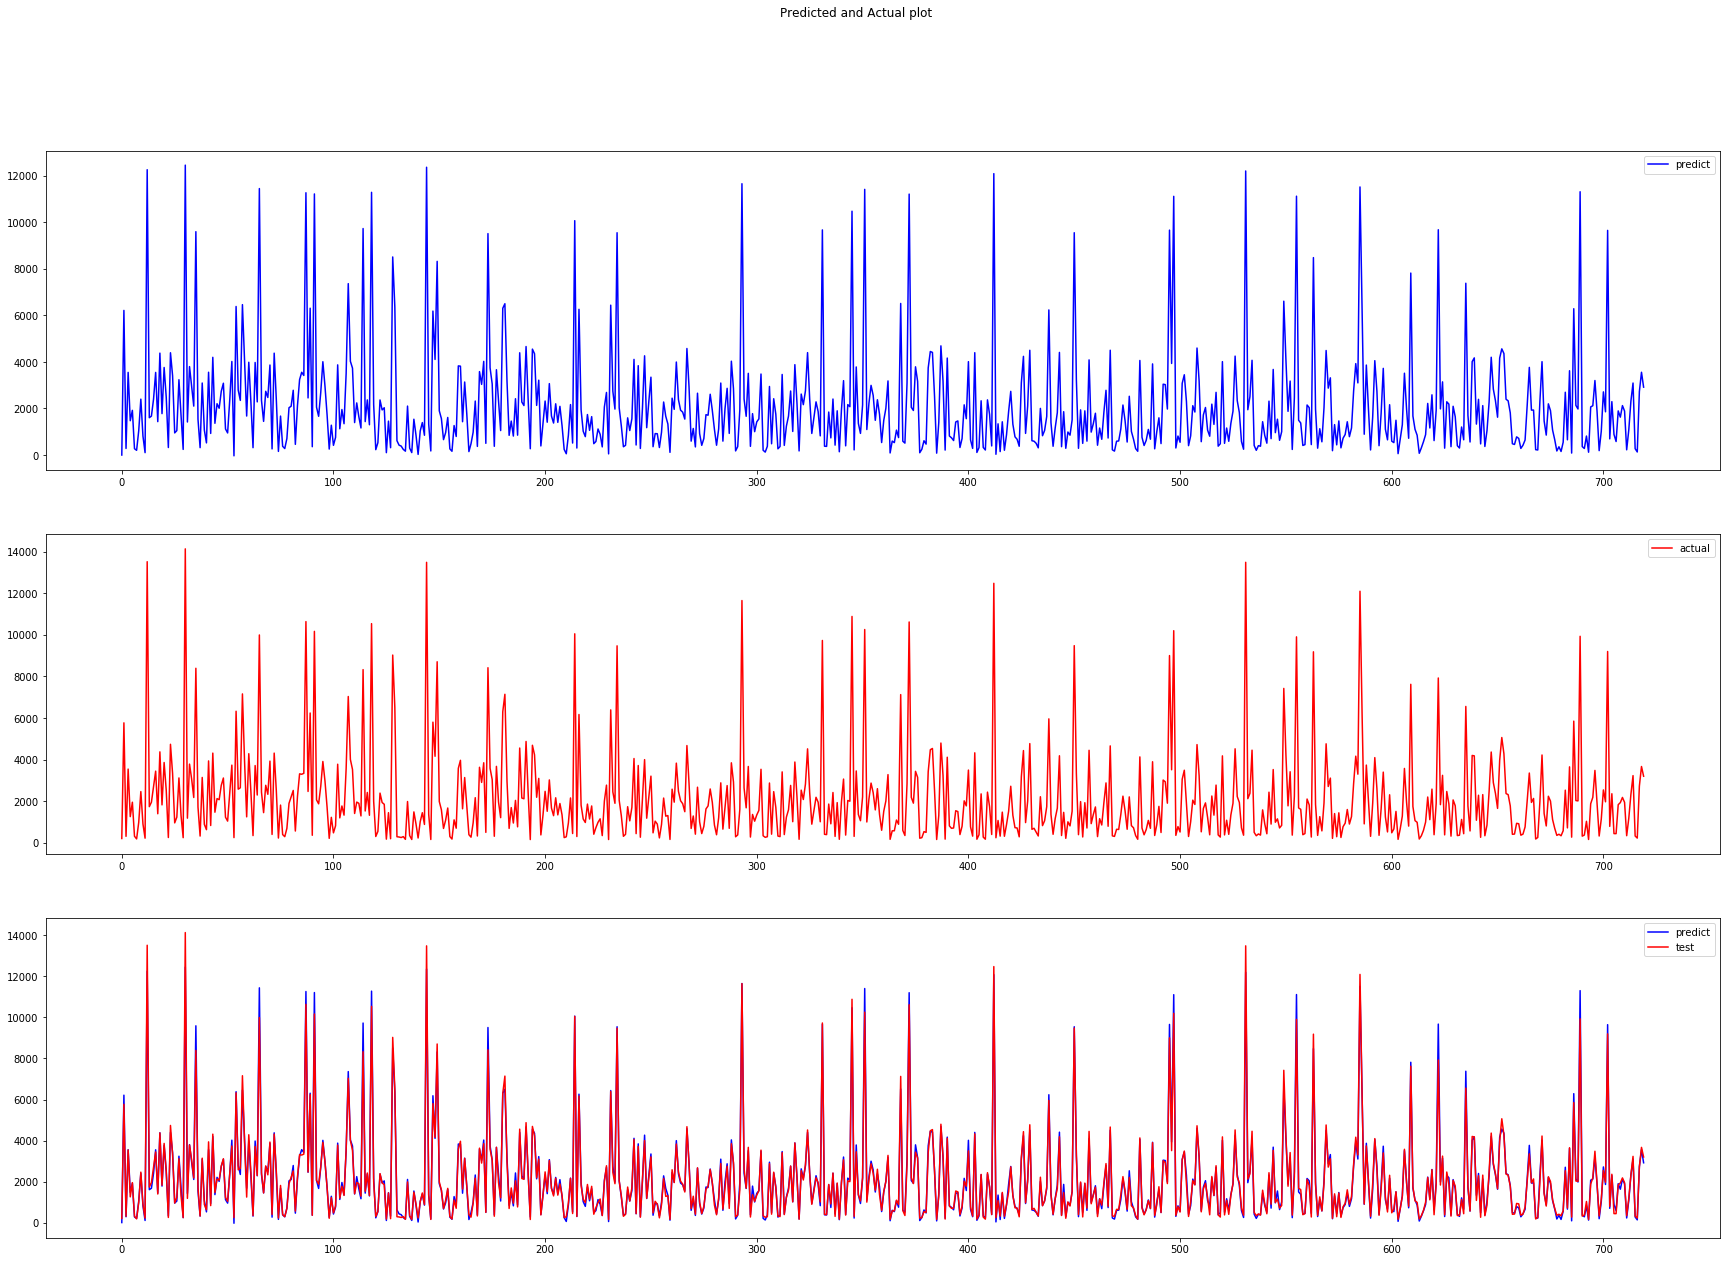

In [24]:
visualization(df_pred.Actual, df_pred.Predicted)